In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
from numpy.random import default_rng
import risktools as rt
from time import time

jump_avgsize = 1
jump_stdv = 0.32
sims = 20
jump_prob = 1
dt = 0.25

elp = pd.Series(
    np.random.lognormal(mean=np.log(jump_avgsize), sigma=jump_stdv, size=sims)
)
jp = pd.Series(np.random.poisson(lam=jump_prob * dt, size=sims))

Half-life of theta in days =  8.73365447505531
2
3


<AxesSubplot: >

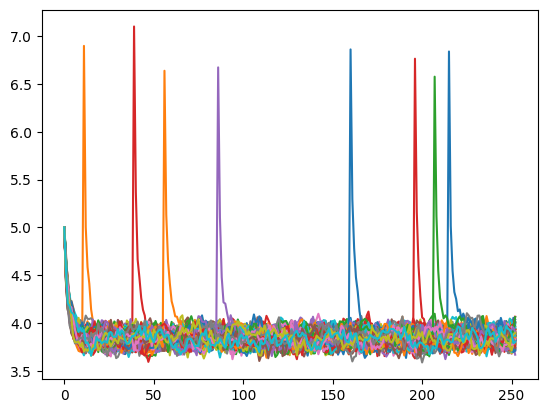

In [7]:
rt.simOUJ(s0=5, mu=4, theta=20, T=1, dt=1/252, jump_avgsize=3.0, c=True).iloc[:,:100].plot(legend=False)

In [8]:
eps = np.array([0.1,-0.2,0.5,0.3,-0.4,-0.3,0.2,0.1,-0.2,0.5,0.3,-0.4,-0.3,0.2,0.1,0.5])
eps = np.c_[eps, eps]

In [9]:
eps.shape

(16, 2)

In [21]:
elp = np.ones(eps.shape)

In [25]:
ejp = np.zeros(eps.shape)

In [26]:
ejp[5,:] = 1

In [67]:
rt.simOUJ(T=4, s0=5, mu=4, theta=2, dt=0.25, sigma=0.32, jump_avgsize=1, jump_prob=0.1, jump_stdv=0.32, eps=eps, elp=elp, ejp=ejp, sims=2)

Half-life of theta in days =  87.3365447505531


,0,1
0,5.000000,5.000000
1,2.330000,2.330000
2,4.084490,4.084490
3,4.034475,4.034475
4,3.956861,3.956861
5,3.591126,3.591126
6,4.973355,4.973355
7,2.463415,2.463415
8,4.272282,4.272282
9,3.340322,3.340322


In [123]:
sigma = np.ones((252, sims)) * 0.1

In [124]:
sigma[100:,:] = 0.5

In [125]:
ss = rt.simOUJ(sigma=sigma, theta=20, T=1, dt=1/252, sims=sims, seed=12345)#.iloc[:,:100].plot(legend=False)

Half-life of theta in days =  8.73365447505531


<AxesSubplot: >

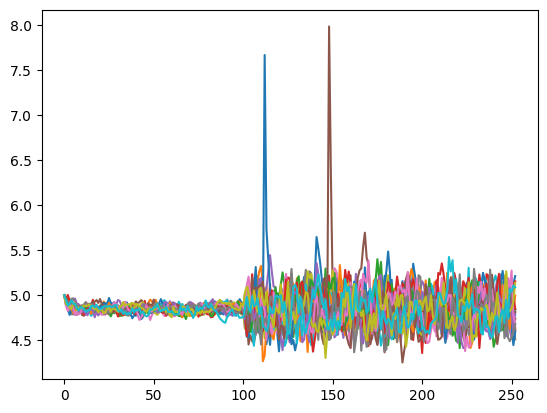

In [126]:
ss.iloc[:,:100].plot(legend=False)

In [127]:
ss.iloc[152,:].std()/ss.iloc[25,:].std() > 3

True